In [1]:
import pandas as pd
import time
import geopandas
from glob import glob
from shapely.ops import cascaded_union
import pickle
import matplotlib.pyplot as plt

In [2]:
bids = pd.read_csv("data/all_bids.csv")[["round", "bidder", "tier", "latency", "census_id"]]
bids["state"] = bids["census_id"]//10000000000
bids = bids.drop_duplicates(subset=["bidder", "census_id"])
bids

,round,bidder,tier,latency,census_id,state
0,1,Rainbow Communications LLC,Gigabit,Low,200050816001,20
1,1,Rainbow Communications LLC,Gigabit,Low,200050816002,20
2,1,Rainbow Communications LLC,Gigabit,Low,200050816003,20
3,1,Rainbow Communications LLC,Gigabit,Low,200050816005,20
4,1,Rainbow Communications LLC,Gigabit,Low,200050817002,20
...,...,...,...,...,...,...
4038929,13,Consortium of AEG and Heron Broadband I,Gigabit,Low,271159503002,27
4038930,13,Consortium of AEG and Heron Broadband I,Gigabit,Low,271159504001,27
4039029,13,Consortium of AEG and Heron Broadband I,Gigabit,Low,270753701003,27
4039401,13,Consortium of AEG and Heron Broadband I,Gigabit,Low,550539604003,55


In [3]:
existing = pd.read_csv("data/existing_service.csv", encoding="latin")
existing["bg"] = existing["BlockCode"]//1000
existing  = existing.loc[(existing["MaxAdDown"]>=25) & (existing["MaxAdUp"]>=3) & (existing["TechCode"]!=60)]
existing["state"] = existing["bg"]//10000000000
existing['names'] = [frozenset(x) for x in zip(existing.ProviderName, existing.HoldingCompanyName, existing.DBAName, existing.HocoFinal)]
existing

,LogRecNo,Provider_Id,FRN,ProviderName,DBAName,HoldingCompanyName,HocoNum,HocoFinal,StateAbbr,BlockCode,TechCode,Consumer,MaxAdDown,MaxAdUp,Business,bg,state,names
0,1,59590,17678236,Webformix Company,Webformix,Webformix Company,290118,Webformix Company,OR,410139501002019,70,1,40.0,10.0,1,410139501002,41,"(Webformix Company, Webformix)"
1,2,59590,17678236,Webformix Company,Webformix,Webformix Company,290118,Webformix Company,OR,410139503002023,70,1,40.0,10.0,1,410139503002,41,"(Webformix Company, Webformix)"
2,3,59590,17678236,Webformix Company,Webformix,Webformix Company,290118,Webformix Company,OR,410139502002027,70,1,40.0,10.0,1,410139502002,41,"(Webformix Company, Webformix)"
3,4,59590,17678236,Webformix Company,Webformix,Webformix Company,290118,Webformix Company,OR,410139501003004,70,1,40.0,10.0,1,410139501003,41,"(Webformix Company, Webformix)"
4,5,59590,17678236,Webformix Company,Webformix,Webformix Company,290118,Webformix Company,OR,410139504001109,70,1,40.0,10.0,1,410139504001,41,"(Webformix Company, Webformix)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42151570,42151571,79963,21999305,OSNET Wireless Corp.,OSNET Wireless,OSNET Wireless Corp.,420091,Osnet Wireless Corp.,PR,720054006003006,70,1,30.0,10.0,1,720054006003,72,"(Osnet Wireless Corp., OSNET Wireless Corp., O..."
42151571,42151572,79963,21999305,OSNET Wireless Corp.,OSNET Wireless,OSNET Wireless Corp.,420091,Osnet Wireless Corp.,PR,720054006003005,70,1,30.0,10.0,1,720054006003,72,"(Osnet Wireless Corp., OSNET Wireless Corp., O..."
42151572,42151573,79963,21999305,OSNET Wireless Corp.,OSNET Wireless,OSNET Wireless Corp.,420091,Osnet Wireless Corp.,PR,720054006003004,70,1,30.0,10.0,1,720054006003,72,"(Osnet Wireless Corp., OSNET Wireless Corp., O..."
42151573,42151574,79963,21999305,OSNET Wireless Corp.,OSNET Wireless,OSNET Wireless Corp.,420091,Osnet Wireless Corp.,PR,720054006003003,70,1,30.0,10.0,1,720054006003,72,"(Osnet Wireless Corp., OSNET Wireless Corp., O..."


In [4]:
existing_bg = set(existing["bg"].tolist())
bid_bg = set(bids["census_id"].tolist())
print(len(existing_bg))
print(len(bid_bg))
print(len(existing_bg.intersection(bid_bg)))


219391
61766
61021


In [5]:
eligible = pd.read_csv("data/auction904_updated_block_cbg.csv")
eligible_bg = eligible["cbg_id"].tolist()
print(len(set(eligible_bg)))
eligible_b = eligible["block_id"].tolist()
existing_b = set(existing["BlockCode"].tolist())
print(len(existing_b))
print(len(eligible_b))
intersect = existing_b.intersection(eligible_b)
print(len(existing_b.intersection(eligible_b)))
print(list(intersect)[:5])


61766
8063170
786952
292114
[170679543005184, 170679543005185, 170679543005186, 170679543005187, 170679543005188]


In [6]:
shapefiles = glob("data/all_data/*.shp")
county_shapes = []
for file in  shapefiles:
    county_shapes.append(geopandas.read_file(file))

county_shapes = pd.concat(county_shapes)[["STATEFP", "COUNTYFP", "TRACTCE", "BLKGRPCE", "GEOID", "geometry"]]
county_shapes["GEOID"] = pd.to_numeric(county_shapes["GEOID"])
county_shapes

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,geometry
0,05,143,010503,2,51430105032,"POLYGON ((-94.21915 36.17593, -94.21718 36.175..."
1,05,143,010504,1,51430105041,"POLYGON ((-94.33762 35.97984, -94.33724 35.980..."
2,05,143,010504,5,51430105045,"POLYGON ((-94.43864 35.95907, -94.43852 35.959..."
3,05,143,010506,1,51430105061,"POLYGON ((-94.24059 36.04502, -94.24058 36.045..."
4,05,135,470200,7,51354702007,"POLYGON ((-91.54745 36.26023, -91.54734 36.260..."
...,...,...,...,...,...,...
3921,24,003,740601,4,240037406014,"POLYGON ((-76.77774 39.11425, -76.77746 39.114..."
3922,24,510,160500,1,245101605001,"POLYGON ((-76.66090 39.30614, -76.66017 39.306..."
3923,24,510,160500,2,245101605002,"POLYGON ((-76.65502 39.29848, -76.65464 39.298..."
3924,24,510,160500,3,245101605003,"POLYGON ((-76.65941 39.29463, -76.65892 39.294..."


In [7]:
try:
    state_shapes = pickle.load(open("state_shapes.pkl", "rb" ))
except FileNotFoundError:
    state_shapes = county_shapes.groupby("STATEFP")["geometry"].apply(list).reset_index(name="geometry")
    state_shapes["geometry"] = state_shapes["geometry"].apply(cascaded_union)
    state_shapes = geopandas.GeoDataFrame(state_shapes)
    for index, row in state_shapes.iterrows():
        neighbors = state_shapes[~state_shapes.geometry.disjoint(row['geometry'])]
        state_shapes.at[index, "neighbors"] = ", ".join(neighbors.STATEFP.tolist())
    with open('state_shapes.pkl', 'wb') as f:
        pickle.dump(state_shapes, f)

        state_shapes

In [8]:
try:
    processed_bid_dict = pickle.load(open("neighbors.pkl", "rb" ))
except FileNotFoundError:
    with open("neighbors.log", "w") as log:
        pass

    total_time = 0
    processed_bid_dict = {}
    for state_code in state_shapes["STATEFP"].tolist():
        start = time.time()
        state_bids = bids.loc[bids["state"]==int(state_code)]
        state_bids = state_bids.groupby("census_id")["bidder"].apply(set).reset_index(name="bidder")
        state_bids = state_bids.merge(county_shapes, left_on="census_id", right_on="GEOID")

        neighbors = state_shapes.loc[state_shapes["STATEFP"] == state_code]["neighbors"].item().split(", ")
        neighbors = [int(n) for n in neighbors]
        state_existing = existing.loc[existing["state"].isin(neighbors)]
        state_existing = state_existing.groupby("bg")["names"].apply(set).reset_index(name="names")
        state_existing = state_existing.merge(county_shapes, left_on="bg", right_on="GEOID")
        state_existing = geopandas.GeoDataFrame(state_existing)

        for index, row in state_bids.iterrows():
            neighbors = state_existing[~state_existing.geometry.disjoint(row['geometry'])]
            ids = neighbors.GEOID.tolist()
            list_set_set_names = neighbors.names.tolist()
            bidders = row.bidder
            out = {}
            for idx, set_set_names in zip(ids, list_set_set_names):
                for name_possibilities in set_set_names:
                    for bidder in bidders:
                        if bidder in name_possibilities:
                            running = out.get(bidder, [])
                            running.append(idx)
                            out[bidder] = running
            state_bids.at[index, "neighbors"] = [out]
        state_time = time.time()-start
        with open("neighbors.log", "a") as log:
            log.write(f"{state_code} {state_time}\n")
        total_time += state_time
        processed_bid_dict[state_code] = state_bids


    with open("neighbors.log", "a") as log:
        log.write(f"final time {total_time}")

    with open('neighbors.pkl', 'wb') as f:
        pickle.dump(processed_bid_dict, f)

In [9]:
all_neighbors = {}
all_bidders = {}
for state, table in processed_bid_dict.items():
    neighbors = {}
    bidders = {}
    for index, row in table.iterrows():
        for k, v in row.neighbors[0].items():
            running = neighbors.get(k, [])
            running += v
            neighbors[k] = running

            running = bidders.get(k, [])
            running.append(row.GEOID)
            bidders[k] = running
    print(state)
    for k, v in bidders.items():
        print(k, len(v))
    for k, v in neighbors.items():
        print(k, len(v))
    all_neighbors[state] = neighbors
    all_bidders[state] = bidders

01
CenturyLink, Inc. 212
Point Broadband Fiber Holding, LLC 17
CenturyLink, Inc. 1099
Point Broadband Fiber Holding, LLC 55
02
04
Ponderosa Communications, Inc. 2
CenturyLink, Inc. 117
Cox Communications, Inc. 22
Ponderosa Communications, Inc. 7
CenturyLink, Inc. 737
Cox Communications, Inc. 179
05
CenturyLink, Inc. 198
Cox Communications, Inc. 21
Verizon Communications Inc. 2
Central Arkansas Telephone Cooperative, Inc. 6
Mountain View Telephone Company 2
CenturyLink, Inc. 1124
Cox Communications, Inc. 145
Verizon Communications Inc. 2
Central Arkansas Telephone Cooperative, Inc. 18
Mountain View Telephone Company 15
06
Cal.net, Inc. 259
Conifer Communications 12
Verizon Communications Inc. 44
Zito West Holding, LLC 2
Cox Communications, Inc. 145
Ultimate Internet Access, Inc. 25
Hankins Information Technology 17
Surfnet Communications 27
Wilson Creek Communications, LLC 5
San Bruno CityNet Services 11
LICT Corporation 1
Cal.net, Inc. 1566
Conifer Communications 86
Verizon Communicati

30
Tri County Telephone Association, Inc. 23
CenturyLink, Inc. 61
Montana Internet Corporation 10
Blackfoot Telephone Cooperative, Inc. 8
Siyeh Communications 1
Tri County Telephone Association, Inc. 54
CenturyLink, Inc. 344
Montana Internet Corporation 73
Blackfoot Telephone Cooperative, Inc. 30
Siyeh Communications 1
31
LTD Broadband LLC 257
Skybeam, LLC 210
AMG Technology Investment Group LLC 134
Visionary Communications, Inc. 16
CenturyLink, Inc. 46
Western Iowa Wireless 40
Spiral Communications, LLC 12
Cox Communications, Inc. 6
Skywave Wireless, Inc. 3
Bluestem Network LLC 25
LTD Broadband LLC 1322
Skybeam, LLC 1383
AMG Technology Investment Group LLC 699
Visionary Communications, Inc. 52
CenturyLink, Inc. 246
Western Iowa Wireless 80
Spiral Communications, LLC 33
Cox Communications, Inc. 42
Skywave Wireless, Inc. 3
Bluestem Network LLC 51
32
Cox Communications, Inc. 18
CenturyLink, Inc. 12
Skybeam, LLC 52
Valley Communications Association, LLC 20
Zito West Holding, LLC 15
Cox Co

<AxesSubplot:>

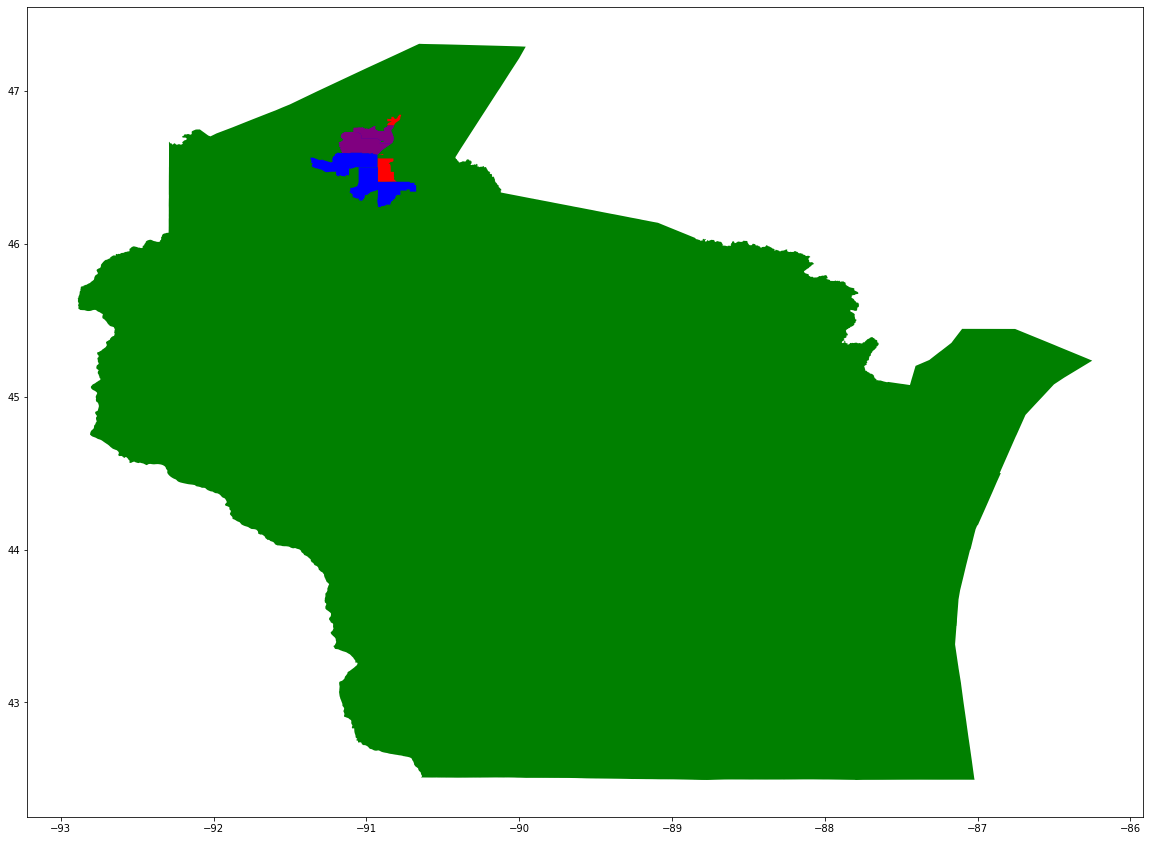

In [10]:
state = "55"
selected_bidder = "Norvado, Inc."
df = geopandas.GeoDataFrame(columns=['color', 'geometry'])
df1 = geopandas.GeoDataFrame(columns=['color', 'geometry'])
df2 = geopandas.GeoDataFrame(columns=['color', 'geometry'])
df3 = geopandas.GeoDataFrame(columns=['color', 'geometry'])
df4 = geopandas.GeoDataFrame(columns=['color', 'geometry'])

df.loc[0] = ['green', state_shapes.loc[state_shapes["STATEFP"] == state].geometry.item()] 

n = set(all_neighbors[state][selected_bidder])
b = set(all_bidders[state][selected_bidder])
combined = n.intersection(b)

df1["geometry"] = county_shapes.loc[county_shapes.GEOID.isin(n)].geometry
df1["color"] = "red"

df2["geometry"] = county_shapes.loc[county_shapes.GEOID.isin(b)].geometry
df2["color"] = "blue"

df3["geometry"] = county_shapes.loc[county_shapes.GEOID.isin(combined)].geometry
df3["color"] = "purple"

df = pd.concat([df, df1, df2, df3])

df.plot(color=df['color'], figsize=(20, 15))


<AxesSubplot:>

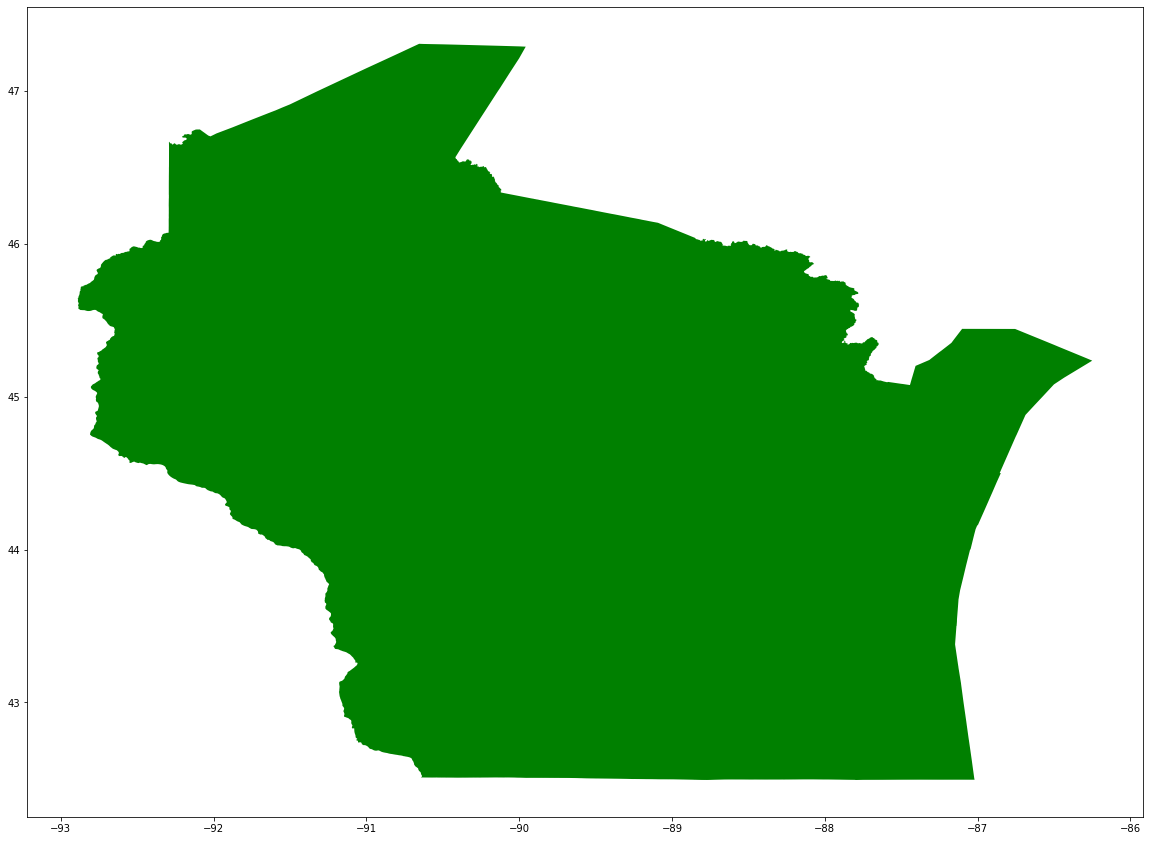

In [11]:
df = geopandas.GeoDataFrame(columns=['color', 'geometry'])
df1 = geopandas.GeoDataFrame(columns=['color', 'geometry'])
df2 = geopandas.GeoDataFrame(columns=['color', 'geometry'])
df3 = geopandas.GeoDataFrame(columns=['color', 'geometry'])
df4 = geopandas.GeoDataFrame(columns=['color', 'geometry'])
df5 = geopandas.GeoDataFrame(columns=['color', 'geometry'])

df.loc[0] = ['green', state_shapes.loc[state_shapes["STATEFP"] == state].geometry.item()] 

bid = set(processed_bid_dict[state].GEOID)
elig = set(eligible.loc[eligible.state_abbreviation=="MO"].cbg_id)
exis = set(existing.loc[existing.state==int(state)].bg).intersection(elig)
fresh = elig - exis

df1["geometry"] = county_shapes.loc[county_shapes.GEOID.isin(exis)].geometry
df1["color"] = "red"

df2["geometry"] = county_shapes.loc[county_shapes.GEOID.isin(exis.intersection(bid))].geometry
df2["color"] = "blue"

df3["geometry"] = county_shapes.loc[county_shapes.GEOID.isin(fresh)].geometry
df3["color"] = "purple"

df3["geometry"] = county_shapes.loc[county_shapes.GEOID.isin(fresh.intersection(bid))].geometry
df3["color"] = "orange"

df = pd.concat([df, df1, df2, df3, df4, df5])

df.plot(color=df['color'], figsize=(20, 15))


In [12]:
processed_bid_dict[state]["num_bidders"] = processed_bid_dict[state].bidder.apply(len)

<AxesSubplot:>

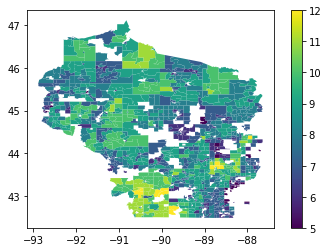

In [13]:
fig, ax = plt.subplots(1, 1)
geopandas.GeoDataFrame(processed_bid_dict[state]).plot(column="num_bidders", ax=ax, legend=True, figsize=(20,15)) 

<AxesSubplot:>

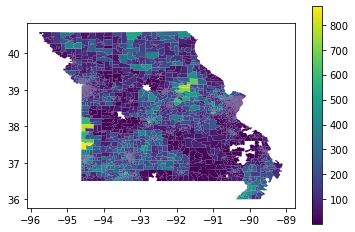

In [14]:
df = existing.loc[existing["state"]==29].groupby("bg")["names"].apply(len).reset_index(name="num_existing")
df = df.merge(county_shapes, left_on="bg", right_on="GEOID")
fig, ax = plt.subplots(1, 1)
geopandas.GeoDataFrame(df).plot(column= "num_existing",ax=ax, legend=True, figsize=(20,15)) 

In [15]:
def explode_processed_bids(processed_bid_dict):
    list_of_rows = []
    for k, v in processed_bid_dict.items():
        for idx, row in v.iterrows():
            for bidder, neighboring_bg in row.neighbors[0].items():
                list_of_rows.append([bidder, row.bidder, row.GEOID, row.geometry, [neighboring_bg]])
    return geopandas.GeoDataFrame(list_of_rows, columns=["bidder", "competitors", "GEOID", "geometry", "neighbors"])
exploded_df = explode_processed_bids(processed_bid_dict)

[550039505001]
[550079601001, 550079603002, 550079603003]
[550039504003, 550079603002, 550079603003]
[550039505001, 550079603003]
[550039505001]


In [16]:
all_bids_by_bidder = bids.groupby("bidder")["census_id"].apply(set).reset_index(name="all_bids")
all_bids_by_bidder = {k:v for k, v in zip(all_bids_by_bidder.bidder, all_bids_by_bidder.all_bids)}
all_neighbored_bids_by_bidder = exploded_df.groupby("bidder")["GEOID"].apply(set).reset_index(name="all_bids")
all_neighbored_bids_by_bidder = {k:v for k, v in zip(all_neighbored_bids_by_bidder.bidder, all_neighbored_bids_by_bidder.all_bids)}
all_neighbors_by_bidder = exploded_df.groupby("bidder")["neighbors"].apply(lambda x: set([z for y in x for z in y[0]])).reset_index(name="all_bids")
all_neighbors_by_bidder = {k:v for k, v in zip(all_neighbors_by_bidder.bidder, all_neighbors_by_bidder.all_bids)}

In [17]:
big_table_rows = []
for bidder, all_bids in all_bids_by_bidder.items():
    neighbored_bids = all_neighbored_bids_by_bidder.get(bidder, set())
    neighbors = all_neighbors_by_bidder.get(bidder, set())
    
    wild_tract_bg = all_bids - neighbored_bids
    strict_neighbor_bg = neighbored_bids - neighbors
    existing_bg = neighbored_bids.intersection(neighbors)
    
    big_table_rows.append([bidder, len(wild_tract_bg)/len(all_bids), len(strict_neighbor_bg)/len(all_bids), len(existing_bg)/len(all_bids), len(neighbors)/len(all_bids), len(all_bids)])
big_table_rows = sorted(big_table_rows, key=lambda x:x[2]+x[3])
percent_neighbor_by_bidder = pd.DataFrame(big_table_rows, columns=["bidder", "percentage of wild tract bids", "percentage of strict neighbor bids","percentage of existing bg bids", "average neighbors per bid", "num bids"])
percent_neighbor_by_bidder.to_csv("bidder_neighbor_percentage.csv", index=False)

<AxesSubplot:>

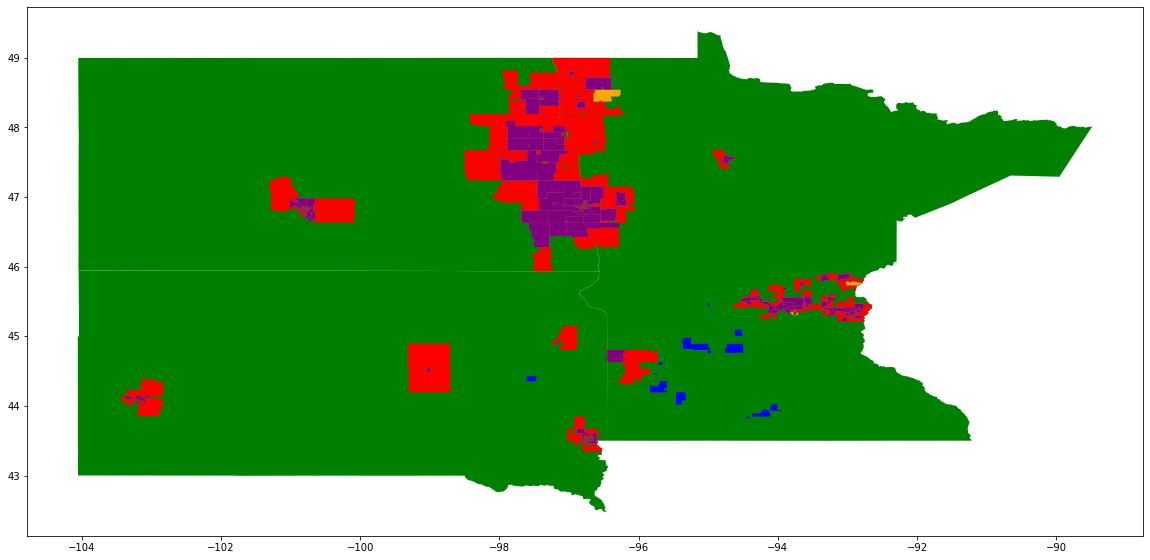

In [18]:
states = ["27", "38", "46"]
selected_bidder = "Midcontinent Communications"
df = geopandas.GeoDataFrame(columns=['color', 'geometry'])
df1 = geopandas.GeoDataFrame(columns=['color', 'geometry'])
df2 = geopandas.GeoDataFrame(columns=['color', 'geometry'])
df3 = geopandas.GeoDataFrame(columns=['color', 'geometry'])
df4 = geopandas.GeoDataFrame(columns=['color', 'geometry'])

df["geometry"] = state_shapes.loc[state_shapes["STATEFP"].isin(states)].geometry
df["color"] = "green"

n = set(all_neighbors_by_bidder[selected_bidder])
h = set(all_neighbored_bids_by_bidder[selected_bidder])
b = set(all_bids_by_bidder[selected_bidder])
combined = n.intersection(b)

df1["geometry"] = county_shapes.loc[county_shapes.GEOID.isin(n)].geometry
df1["color"] = "red"

df2["geometry"] = county_shapes.loc[county_shapes.GEOID.isin(b)].geometry
df2["color"] = "blue"

df3["geometry"] = county_shapes.loc[county_shapes.GEOID.isin(h)].geometry
df3["color"] = "orange"

df4["geometry"] = county_shapes.loc[county_shapes.GEOID.isin(combined)].geometry
df4["color"] = "purple"

df = pd.concat([df, df1, df2, df3, df4])

df.plot(color=df['color'], figsize=(20, 15))
